In [183]:
import cv2
import tifffile as tiff 
import imagecodecs
import rasterio 
# I also want to try using the gdal library > installed by default on colab server and also usable in QGIS. However trouble installing it locally via pipenv
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


In [184]:
img_rgb = cv2.imread("../data/sample_data/example_multispectral.tif")
img_rgb.shape
# this does not work > does only read three color bands 

(2984, 3755, 3)

In [186]:
img_ms_tiff = tiff.imread("../data/sample_data/example_multispectral.tif")
img_ms.shape

# this package should be able to read multi-band images, but mysteriously there are only 4 for our Phantom P4 Multispectral data, where there should be 5, same for rasterio, see below

(2984, 3755, 4)

In [187]:
# da neben der (wie ich dachte) kompletten result.tif 
# alle color bands nochmal einzeln als .tif im Datenordner zu finden sind war meine Idee:
# alle einzeln importieren und schauen welche im gesamt result.tif drin sind und welche nicht

img_rededge_tiff = tiff.imread("../data/sample_data/example_rededge.tif")
img_nir_tiff = tiff.imread("../data/sample_data/example_nir.tif")
img_red_tiff = tiff.imread("../data/sample_data/example_red.tif")
img_green_tiff = tiff.imread("../data/sample_data/example_green.tif")
img_blue_tiff = tiff.imread("../data/sample_data/example_blue.tif")

def replace_nans(array):

    indis = np.where(np.isnan(array))
    array[indis] = 0
    array = array.astype("uint8")

    return(array)

img_nir_tiff = replace_nans(array=img_nir_tiff)
img_rededge_tiff = replace_nans(array=img_rededge_tiff)
img_red_tiff = replace_nans(array=img_red_tiff)
img_green_tiff = replace_nans(array=img_green_tiff)
img_blue_tiff = replace_nans(array=img_blue_tiff)

for i in range(0,4):
    
    if (img_ms_tiff[:,:,i] == img_red_tiff).all():

        print("band " + str(i) + " is Red")

    elif (img_ms_tiff[:,:,i] == img_green_tiff).all():

        print("band " + str(i) + " is Green")

    elif (img_ms_tiff[:,:,i] == img_blue_tiff).all():

        print("band " + str(i) + " is Blue")

    elif (img_ms_tiff[:,:,i] == img_rededge_tiff).all():

        print("band " + str(i) + " is Red Edge")
    
    elif (img_ms_tiff[:,:,i] == img_nir_tiff).all():

        print("band " + str(i) + " is NIR")
    
    else: 
        print("no matching individual color band found for band " + str(i))

    print("---")
    

no matching individual color band found for band 0
---
no matching individual color band found for band 1
---
no matching individual color band found for band 2
---
no matching individual color band found for band 3
---


In [188]:
# Es gibt also bei keinem Band des gesamt result.tif eine exakte Übereinstimmung mit den einzlenen results
# Find ich komisch

# Hier nochmal test für einen Pixel
print("Pixel values for individual bands\n")

print(img_red_tiff[2000, 2000])
print(img_green_tiff[2000, 2000])
print(img_blue_tiff[2000, 2000])
print(img_rededge_tiff[2000, 2000])
print(img_nir_tiff[2000, 2000])

print("\nPixel values for complete result.tif\n")

for i in range(0,4):
    print(img_ms_tiff[2000,2000,i])
    
# --> none of them match?!

Pixel values for individual bands

144
142
14
178
206

Pixel values for complete result.tif

157
143
139
255


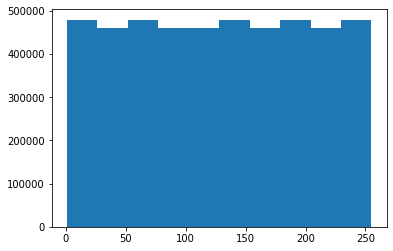

In [189]:
# Look at distribution of color values over pixels
def hist_plot(raw_array):

    flat = raw_array.reshape((-1))
    flat = np.float32(flat)

    plt.hist(flat[flat != 0])
    plt.show()

# einmal für die einzel importierten RED Werte
hist_plot(raw_array=img_red_tiff)

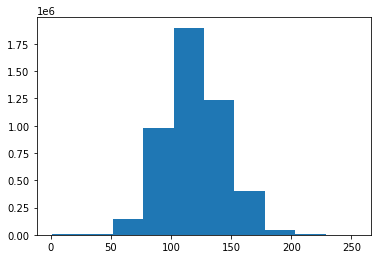

In [190]:
# Und für jeweils die vier Bänder im Gesamt file (result.tif)
# Numero 1
hist_plot(raw_array=img_ms_tiff[:,:,0])

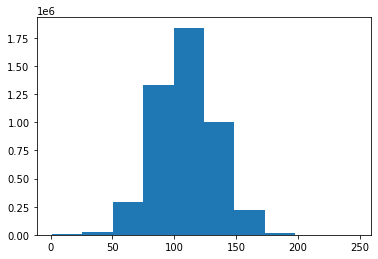

In [192]:
# numero 2
hist_plot(raw_array=img_ms_tiff[:,:,1])

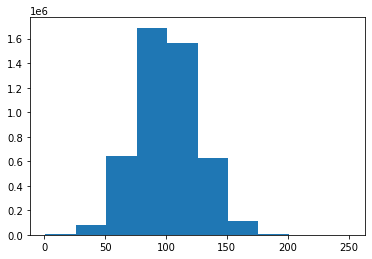

In [193]:
# numero 3
hist_plot(raw_array=img_ms_tiff[:,:,2])

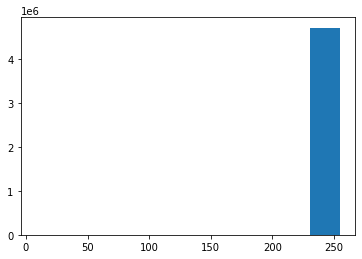

In [194]:
# sieht bislang eher so aus wie ich color histograms für bilder kenne. aber jetzt kommt..
# numero 4
hist_plot(raw_array=img_ms_tiff[:,:,3])

In [195]:
# is the fourth band (index=3) maybe a mask? (ie black and white values only?)
np.unique(img_ms_tiff[:,:,3]) # --> nö, aber Werte sind sehr seltsam?!

array([  0,   8,  16, 239, 247, 255], dtype=uint8)

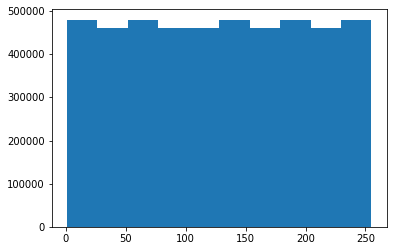

In [196]:
# look at nir and red edge to see how the histograms look like

hist_plot(raw_array=img_rededge_tiff)

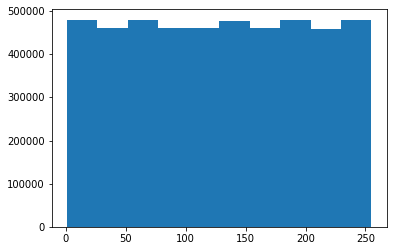

In [197]:
hist_plot(raw_array=img_nir_tiff)

In [198]:
# die histogramme der einzeln importierten Farbbänder sehen alle gleich aus!
# wurden die irgendwie standardisiert oder sowas?

(img_nir_tiff == img_red_tiff).all() # werte sind allerdings nicht alle gleich (sieht man oben auch schon)

False

In [199]:
img_ms_rasterio = rasterio.open("../data/sample_data/example_multispectral.tif").read()
# calculate indices directly in python, see https://gis.stackexchange.com/questions/379762/how-to-calculate-multispectral-vegetation-indices-using-python

# this package makes the best impression. well documented, easy to use but powerful

# is there maybe a difference in what the different raster packages produce when importing data?
print(img_ms_rasterio.shape)
print(img_ms_tiff.shape)
print("\n")

for i in range(0,4):
    
    print((img_ms_rasterio[i,:,:] == img_ms_tiff[:,:,i]).all())

# --> although the format is different, the individual band values are identical

(4, 2984, 3755)
(2984, 3755, 4)


True
True
True
True


In [200]:
# import individual color bands with rasterio package
img_red_rasterio = rasterio.open("../data/sample_data/example_red.tif").read()
img_green_rasterio = rasterio.open("../data/sample_data/example_green.tif").read()
img_blue_rasterio = rasterio.open("../data/sample_data/example_blue.tif").read()
img_rededge_rasterio = rasterio.open("../data/sample_data/example_rededge.tif").read()
img_nir_rasterio = rasterio.open("../data/sample_data/example_nir.tif").read()

In [201]:
target_shape = (img_red_rasterio.shape[1], img_red_rasterio.shape[2])

img_red_new = replace_nans(img_red_rasterio.reshape(target_shape))
img_green_new = replace_nans(img_green_rasterio.reshape(target_shape))
img_blue_new = replace_nans(img_blue_rasterio.reshape(target_shape))
img_rededge_new = replace_nans(img_rededge_rasterio.reshape(target_shape))
img_nir_new = replace_nans(img_nir_rasterio.reshape(target_shape))

print((img_red_new == img_red_tiff).all())
print((img_green_new == img_green_tiff).all())
print((img_blue_new == img_blue_tiff).all())
print((img_rededge_new == img_rededge_tiff).all())
print((img_nir_new == img_nir_tiff).all())
# individual bands also all the same -> this cannot be the reason

True
True
True
True
True
